In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

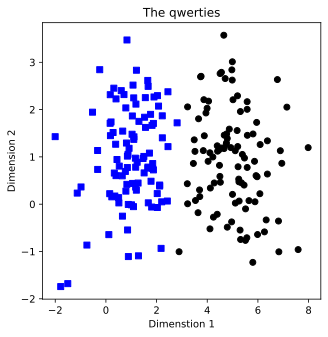

In [13]:
# create data

nPerCLuster = 100
blur = 1

A = [1,1]
B = [5,1]

a = [A[0]+ np.random.randn(nPerCLuster)*blur,A[1]+ np.random.randn(nPerCLuster)*blur]
b = [B[0]+ np.random.randn(nPerCLuster)*blur,B[1]+ np.random.randn(nPerCLuster)*blur]

# true label
labels_np = np.vstack((np.zeros((nPerCLuster,1)),np.ones((nPerCLuster,1))))
 # concatinate into a matrix
data_np = np.hstack((a,b)).T

# convert to pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# plot the data
fig= plt.subplots(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties")
plt.xlabel("Dimenstion 1")
plt.ylabel("Dimension 2")
plt.show()

In [14]:
# build the model

ANNcls = nn.Sequential(
    nn.Linear(2,1),
    nn.ReLU(),
    nn.Linear(1,1),
    nn.Sigmoid(),
)

ANNcls

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)

In [15]:
# other model features

learningRate = 0.01

# loss function
lossFn = nn.BCELoss()

# optimizer
optimizer = torch.optim.SGD(ANNcls.parameters(), lr=learningRate)

In [16]:
# train the model
epochs = 1000
losses = torch.zeros(epochs)

for epochi in range(epochs):
    
    # forward pass
    y_hat = ANNcls(data)
    
    # compute loss
    loss = lossFn(y_hat,labels)
    losses[epochi] = loss.item()
    
    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

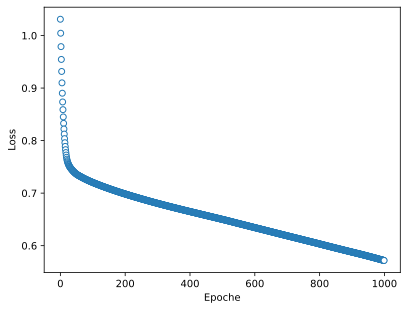

In [17]:
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=1)
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.show()


In [18]:
# compute the prediction

# manually compute losses
# final forward pass
prediction = ANNcls(data)

predLabels = prediction>.5

# find errors
misCls = np.where(predLabels != labels)[0]

# total acc
totalAcc = 100 - 100*len(misCls)/(2*nPerCLuster)

print("Final acc {}%".format(totalAcc))

Final acc 77.5%


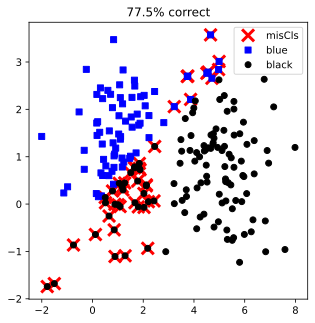

In [19]:
# plot the labeled data

fig = plt.figure(figsize=(5,5))
plt.plot(data[misCls,0],data[misCls,1],'rx',markersize=12,markeredgewidth=3)
plt.plot(data[np.where(~predLabels)[0],0],data[np.where(~predLabels)[0],1],'bs')
plt.plot(data[np.where(predLabels)[0],0],data[np.where(predLabels)[0],1],'ko')

plt.legend(['misCls','blue','black'])
plt.title(f"{totalAcc}% correct")
plt.show()

## Learning rates comparison

In [22]:
# build a model
def buildModel(learning_rate):
    clsModel = nn.Sequential(
    nn.Linear(2,1),
    nn.ReLU(),
    nn.Linear(1,1),
    # nn.Sigmoid(),
    )
    
    # loss function
    lossFn = nn.BCEWithLogitsLoss()
    
    # optimizer
    optimizer = torch.optim.SGD(clsModel.parameters(), lr=learningRate)
    
    return clsModel,lossFn, optimizer

In [24]:
#train model
def trainModel(optimizer,loss_fn,ANNModel):
    # train the model
    epochs = 1000
    losses = torch.zeros(epochs)
    
    for epochi in range(epochs):
        
        # forward pass
        y_hat = ANNModel(data)
        
        # compute loss
        loss = loss_fn(y_hat,labels)
        losses[epochi] = loss.item()
        
        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    predictions = ANNModel(data)
    
    totalAcc = 100*torch.mean(((predictions > 0) == labels).float())
    
    return losses,predictions,totalAcc

Final acc 95.5%


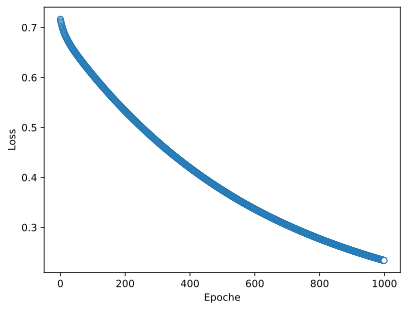

In [28]:
# test new code
ANNcls,lossFn,optimizer = buildModel(.01)

losses,predictions,totalAcc =trainModel(optimizer,lossFn,ANNcls)

print("Final acc {}%".format(totalAcc))

plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=1)
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.show()

In [29]:
learning_rates = np.linspace(0.001,.1,40)

# init result output
accByLR = []
allLosses = np.zeros((len(learning_rates),epochs))


for i,lr in enumerate(learning_rates):
    
    clsModel,lossFn,optimizer = buildModel(lr)
    losses,predictions,totalAcc = trainModel(optimizer,lossFn,clsModel)
    
    # store the result
    accByLR.append(totalAcc)
    allLosses[i,:] = losses.detach()
    
    

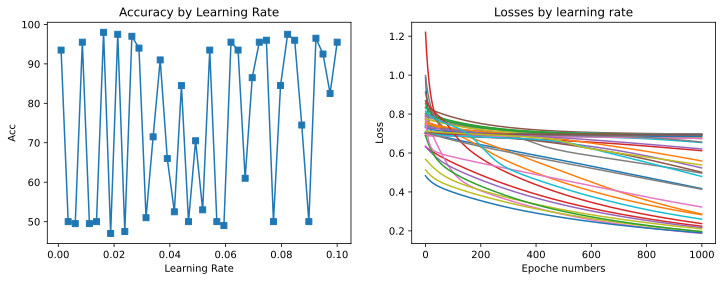

In [30]:

fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(learning_rates,accByLR,'s-')
ax[0].set_xlabel("Learning Rate")
ax[0].set_ylabel("Acc")
ax[0].set_title("Accuracy by Learning Rate")

ax[1].plot(allLosses.T)
ax[1].set_title("Losses by learning rate")
ax[1].set_xlabel("Epoche numbers")
ax[1].set_ylabel("Loss")
plt.show()



In [31]:
# proportaion of runs where the model had atleast 70% acc 
sum(torch.tensor(accByLR)>70)/len(accByLR)

tensor(0.6000)

# Run a meta-experiment

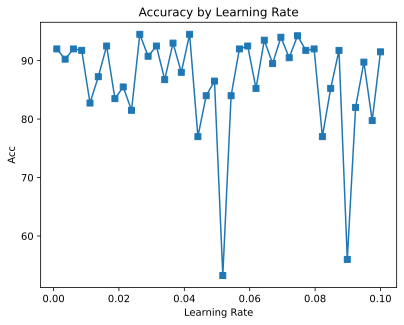

In [33]:
# run a "meta-experiment"


numExp = 50

accMeta = np.zeros((numExp,len(learning_rates)))

num_epoches = 500

for expIdx in range(numExp):
    for i,lr in enumerate(learning_rates):
        
        # create and run the model
        ANNcls,lossFn,optimizer = buildModel(lr)
        losses,predictions,totalAcc = trainModel(optimizer,lossFn,ANNcls)
        
        # store the results
        accMeta[expIdx,i] = totalAcc
        
        
plt.plot(learning_rates,np.median(accMeta,axis=0),'s-')
plt.xlabel("Learning Rate")
plt.ylabel("Acc")
plt.title("Accuracy by Learning Rate")
plt.show()